# 07. Elastic Net Model

**Mô hình:** Elastic Net (L1 + L2 regularization)

**Thư viện:** sklearn.linear_model.ElasticNet

**Metrics:** RMSFE, MAPE

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# Cấu hình hiển thị
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore") # Tắt cảnh báo hội tụ nếu có

# Hàm tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true[y_true == 0] = 1e-10 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Đã import thư viện.")

Đã import thư viện.


In [7]:
# Đọc dữ liệu
df_train = pd.read_csv('../data/processed/train_clean.csv')
df_test = pd.read_csv('../data/processed/test_clean.csv')

# Sửa lỗi encoding tên cột
df_train.columns = [c.replace('垄', '¢') for c in df_train.columns]
df_test.columns = [c.replace('垄', '¢') for c in df_test.columns]

# Đặt index thời gian
df_train['Fecha'] = pd.to_datetime(df_train['Fecha'])
df_test['Fecha'] = pd.to_datetime(df_test['Fecha'])
df_train = df_train.set_index('Fecha')
df_test = df_test.set_index('Fecha')

# Giữ lại các cột chung
common_cols = list(set(df_train.columns) & set(df_test.columns))
df_train = df_train[common_cols]
df_test = df_test[common_cols]

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (112, 190)
Test shape: (28, 190)


In [8]:
# Định nghĩa biến mục tiêu
TARGET_COL = 'Core CPI'

# Tách biến độc lập (X) và biến mục tiêu (y)
X_train = df_train.drop(columns=[TARGET_COL])
y_train = df_train[TARGET_COL]
X_test = df_test.drop(columns=[TARGET_COL])
y_test = df_test[TARGET_COL]

# Khởi tạo và huấn luyện mô hình ElasticNetCV
# l1_ratio: Danh sách các tỷ lệ L1/L2 để thử (từ gần giống Ridge đến gần giống Lasso)
# cv=5: Cross-validation 5-fold
model = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=None, # Tự động chọn dải alpha
    cv=5,
    random_state=42,
    max_iter=10000 # Tăng số vòng lặp để đảm bảo hội tụ
)

model.fit(X_train, y_train)

print(f"Đã huấn luyện xong Elastic Net.")
print(f"Best Alpha: {model.alpha_}")
print(f"Best L1 Ratio: {model.l1_ratio_}")
print(f"Số lượng biến được giữ lại (Hệ số != 0): {np.sum(model.coef_ != 0)} / {X_train.shape[1]}")

Đã huấn luyện xong Elastic Net.
Best Alpha: 0.0063199971946433725
Best L1 Ratio: 0.7
Số lượng biến được giữ lại (Hệ số != 0): 8 / 189


In [9]:
# Dự báo
y_pred = model.predict(X_test)
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Tính Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

# Hiển thị kết quả
df_results = pd.DataFrame({
    'Metric': ['R2 Score', 'RMSE', 'MAE', 'MAPE (%)'],
    'Value': [r2, rmse, mae, mape]
})

print(f"\nKết quả dự báo Elastic Net cho '{TARGET_COL}':")
display(df_results)


Kết quả dự báo Elastic Net cho 'Core CPI':


,Metric,Value
0,R2 Score,0.103756
1,RMSE,0.111195
2,MAE,0.092748
3,MAPE (%),15.793008


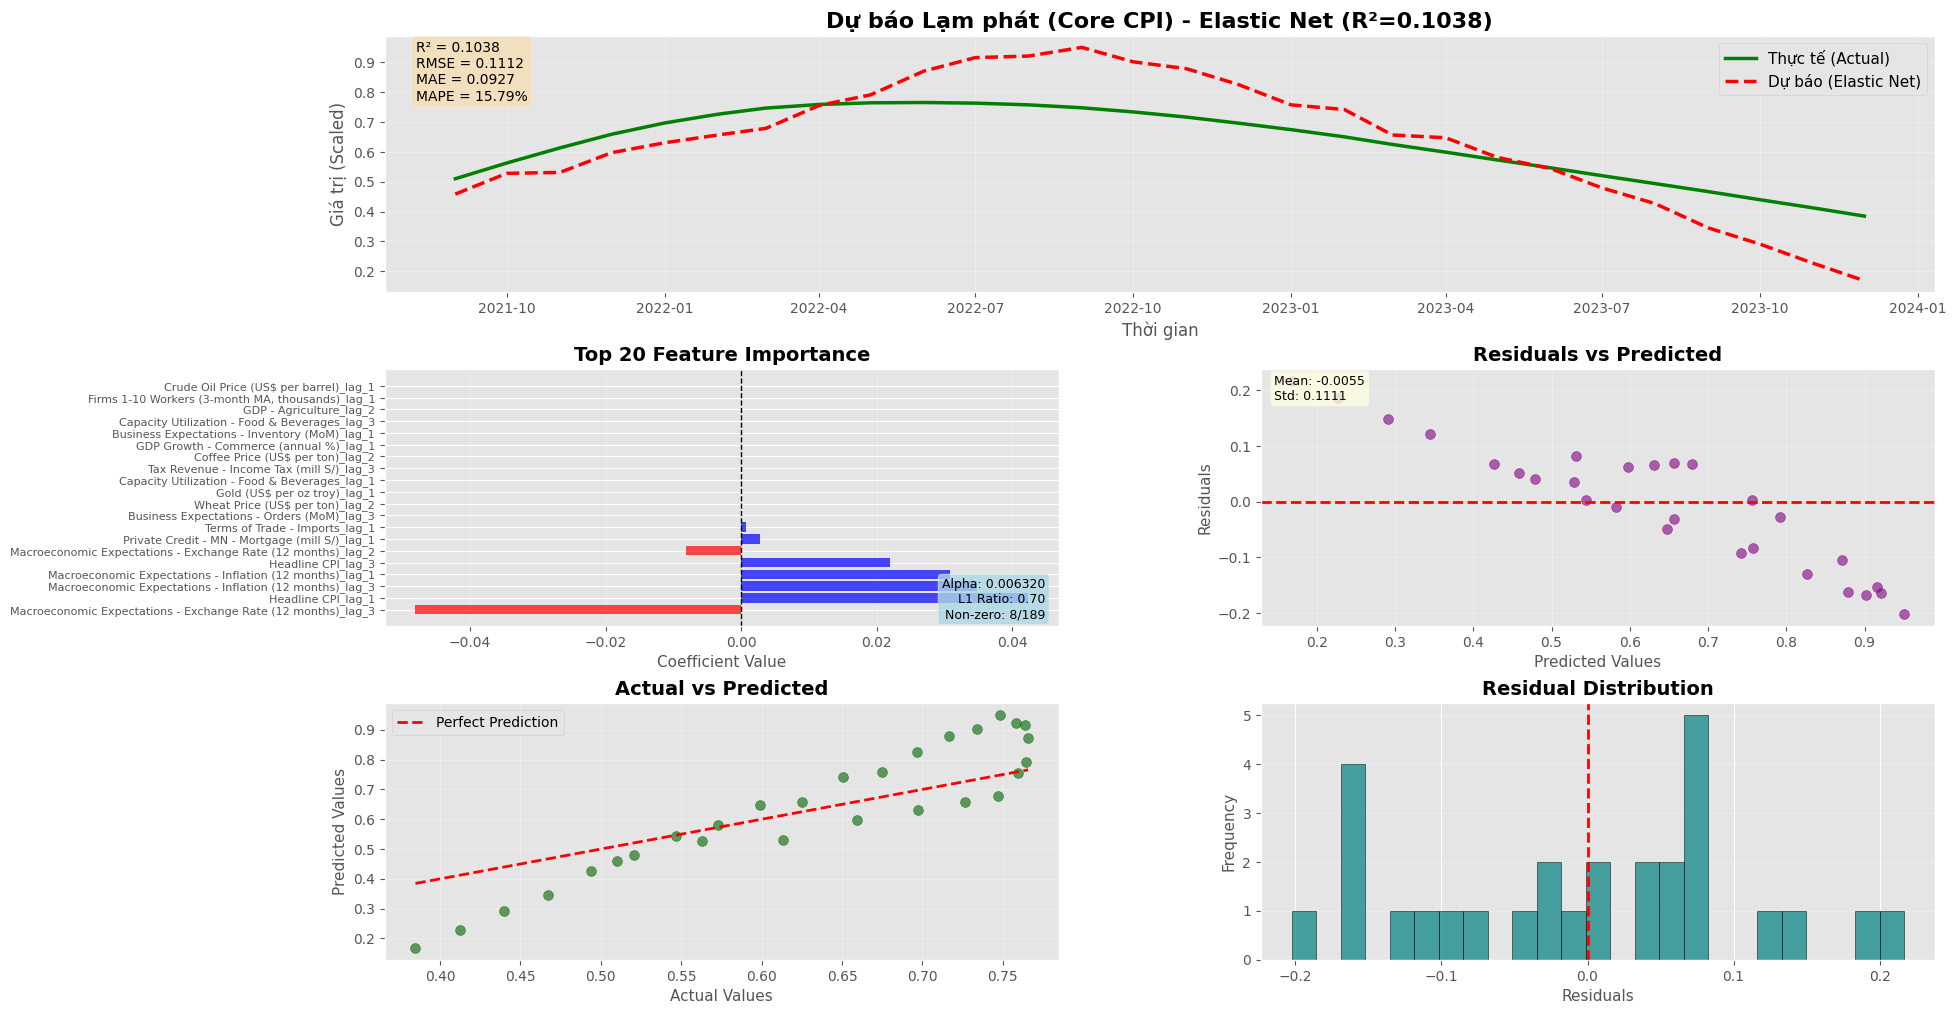

Đã lưu metrics vào: ../results/tables\elasticnet_metrics.csv
Đã lưu predictions vào: ../results/tables\elasticnet_predictions.csv
Đã lưu feature importance vào: ../results/tables\elasticnet_feature_importance.csv
Đã lưu diagnostics plot vào: ../results/figures\elasticnet_diagnostics_plot.png


In [10]:
# Tạo thư mục lưu trữ
OUTPUT_DIR_FIGURE = '../results/figures'
OUTPUT_DIR_TABLE = '../results/tables'
os.makedirs(OUTPUT_DIR_FIGURE, exist_ok=True)
os.makedirs(OUTPUT_DIR_TABLE, exist_ok=True)

# Lưu metrics
table_filename = os.path.join(OUTPUT_DIR_TABLE, 'elasticnet_metrics.csv')
df_results.to_csv(table_filename, index=False)

# Lưu predictions
predictions_df = pd.DataFrame({
    'Fecha': y_test.index,
    'Actual': y_test.values,
    'Predicted': y_pred
})
predictions_filename = os.path.join(OUTPUT_DIR_TABLE, 'elasticnet_predictions.csv')
predictions_df.to_csv(predictions_filename, index=False)

# Lưu feature importance
feature_importance_full = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
})
feature_importance_full = feature_importance_full.sort_values('Abs_Coefficient', ascending=False)
feature_importance_filename = os.path.join(OUTPUT_DIR_TABLE, 'elasticnet_feature_importance.csv')
feature_importance_full.to_csv(feature_importance_filename, index=False)

# === VISUALIZATION ===
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Prediction Plot
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(y_test.index, y_test.values, label='Thực tế (Actual)', color='green', linewidth=2.5)
ax1.plot(y_pred_series.index, y_pred_series.values, label='Dự báo (Elastic Net)', color='red', linestyle='--', linewidth=2.5)
ax1.set_title(f'Dự báo Lạm phát ({TARGET_COL}) - Elastic Net (R²={r2:.4f})', fontsize=16, fontweight='bold')
ax1.set_xlabel('Thời gian', fontsize=12)
ax1.set_ylabel('Giá trị (Scaled)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Add metrics table to prediction plot
metrics_text = f'R² = {r2:.4f}\nRMSE = {rmse:.4f}\nMAE = {mae:.4f}\nMAPE = {mape:.2f}%'
ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Feature Importance (Top 20)
ax2 = fig.add_subplot(gs[1, 0])
feature_importance = feature_importance_full.head(20)

colors = ['red' if c < 0 else 'blue' for c in feature_importance['Coefficient']]
ax2.barh(range(len(feature_importance)), feature_importance['Coefficient'], color=colors, alpha=0.7)
ax2.set_yticks(range(len(feature_importance)))
ax2.set_yticklabels(feature_importance['Feature'], fontsize=8)
ax2.set_xlabel('Coefficient Value', fontsize=11)
ax2.set_title('Top 20 Feature Importance', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

# Add model info
model_text = f'Alpha: {model.alpha_:.6f}\nL1 Ratio: {model.l1_ratio_:.2f}\nNon-zero: {np.sum(model.coef_ != 0)}/{len(model.coef_)}'
ax2.text(0.98, 0.02, model_text, transform=ax2.transAxes, 
         fontsize=9, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# 3. Residual Plot
ax3 = fig.add_subplot(gs[1, 1])
residuals = y_test.values - y_pred
ax3.scatter(y_pred, residuals, alpha=0.6, color='purple', s=50)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_title('Residuals vs Predicted', fontsize=14, fontweight='bold')
ax3.set_xlabel('Predicted Values', fontsize=11)
ax3.set_ylabel('Residuals', fontsize=11)
ax3.grid(True, alpha=0.3)

# Add residual stats
residual_text = f'Mean: {np.mean(residuals):.4f}\nStd: {np.std(residuals):.4f}'
ax3.text(0.02, 0.98, residual_text, transform=ax3.transAxes, 
         fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# 4. Actual vs Predicted
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(y_test.values, y_pred, alpha=0.6, color='darkgreen', s=50)
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax4.set_title('Actual vs Predicted', fontsize=14, fontweight='bold')
ax4.set_xlabel('Actual Values', fontsize=11)
ax4.set_ylabel('Predicted Values', fontsize=11)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# 5. Residual Distribution
ax5 = fig.add_subplot(gs[2, 1])
ax5.hist(residuals, bins=25, color='teal', alpha=0.7, edgecolor='black')
ax5.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax5.set_title('Residual Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Residuals', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.grid(True, alpha=0.3, axis='y')

# Lưu biểu đồ
figure_filename = os.path.join(OUTPUT_DIR_FIGURE, 'elasticnet_diagnostics_plot.png')
plt.savefig(figure_filename, bbox_inches='tight', dpi=300)
plt.show()

print(f"Đã lưu metrics vào: {table_filename}")
print(f"Đã lưu predictions vào: {predictions_filename}")
print(f"Đã lưu feature importance vào: {feature_importance_filename}")
print(f"Đã lưu diagnostics plot vào: {figure_filename}")